#Library

In [75]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
from pathlib import Path


ModuleNotFoundError: No module named 'tensorflow.keras.legacy'

# **Prepare datasets**

In [33]:
df= pd.read_csv(r'../../data/train_preprocess.tsv.txt', sep='\t', header=None)

In [34]:
df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [35]:
df.shape

(11000, 2)

In [36]:
df.columns =['text', 'label']
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#Check Data

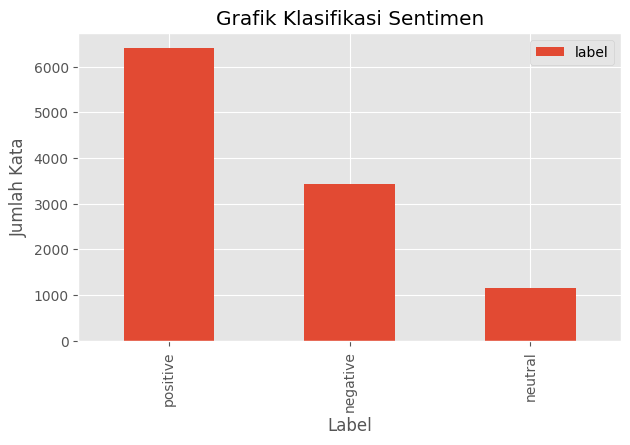

In [37]:
df["label"].value_counts().plot.bar(figsize=(7,4))
plt.title('Grafik Klasifikasi Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()


In [38]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 11000 data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [39]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

def cleansing(sent):
  string = sent.lower()
  string = re.sub(r'[^a-zA-z0-9]',' ', string)
  string = re.sub(r'[^\w]',' ', string)

  words = nltk.word_tokenize(string)
  words = [word for word in words if word not in stop_words]

  text = ' '.join(words)
  return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogimurdani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yogimurdani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
df['text_clean'] = df.text.apply(cleansing)

In [41]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung nya ny...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh mahasiswa sombong kasih kartu kuning belaj...


#Sortir Data Berdasarkan 3 Sentimen

In [42]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


#Feature Extraction

In [70]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [71]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


#Split Dataset For Training & Testing

In [72]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training (RNN)

In [77]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SimpleRNN(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
adam=optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 79, 100)           10000000  
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 64)                10560     
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 10,010,755
Trainable params: 10,010,755
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
880/880 [==============================] - 20s 23ms/step - loss: 0.5713 - accuracy: 0.7683 - val_loss: 0.4755 - val_accuracy: 0.8050
Epoch 2/10
880/880 [==============================] - 20s 23ms/step - loss: 0.2152 - accuracy: 0.9189 - val_loss: 0.4773 - val_accuracy: 0.8200
Epoch 2: ear

#Evaluation

In [78]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

69/69 [==============================] - 0s 2ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       685
           1       0.72      0.63      0.67       233
           2       0.88      0.89      0.89      1282

    accuracy                           0.82      2200
   macro avg       0.78      0.76      0.77      2200
weighted avg       0.82      0.82      0.82      2200



#Cross Validation

In [81]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    adam=optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


Epoch 1/10
880/880 [==============================] - 20s 23ms/step - loss: 0.5522 - accuracy: 0.7680 - val_loss: 0.4276 - val_accuracy: 0.8305
Epoch 2/10
880/880 [==============================] - 20s 22ms/step - loss: 0.1893 - accuracy: 0.9303 - val_loss: 0.5233 - val_accuracy: 0.8068
Epoch 2: early stopping
69/69 [==============================] - 0s 2ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       685
           1       0.73      0.67      0.70       233
           2       0.88      0.86      0.87      1282

    accuracy                           0.81      2200
   macro avg       0.77      0.76      0.77      2200
weighted avg       0.81      0.81      0.81      2200

Epoch 1/10
880/880 [==============================] - 19s 22ms/step - loss: 0.5513 - accuracy: 0.7750 - val_loss: 0.4088 - val_accuracy: 0.8468
Epoch 2/10
880/880 [==============================] - 19s 21ms/step - loss: 0.1937 - accuracy: 

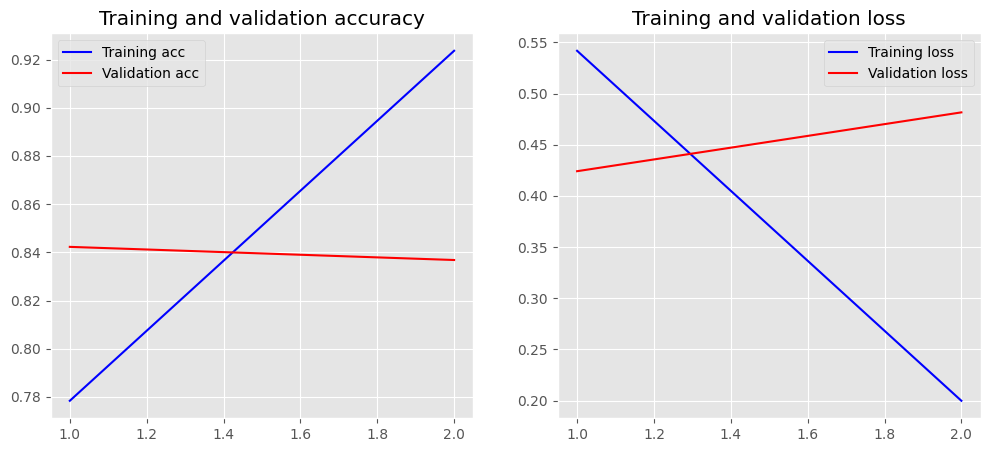

In [82]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

#Export Model

In [83]:
model.save('model_rnn.h5')
print('Model has created!')

Model has created!


#Testing Model

In [85]:
input_text = """ 
mencuri uang
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_rnn.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 58ms/step
Text:  mencuri uang
Sentiment:  negative
